# Day 58：经典时序模型 2（ARIMA / 季节性 / 残差诊断）

本节课在 **AR / MA / ARMA** 的基础上继续推进：当序列存在 **趋势** 或 **季节性**（非平稳）时，如何通过 **差分** 把问题“变回平稳”，再用 **ARIMA / SARIMAX** 建模，并用 **Ljung-Box** 等方法检查残差是否已经“像白噪声”。


## 学习目标

完成本 Notebook 后你应该能够：

1. 理解 **滞后（lag）**、**平稳性（stationarity）**、**差分（differencing）** 的含义。
2. 会用 **ADF 检验**判断序列是否平稳（以及差分后是否更接近平稳）。
3. 会用 **ACF / PACF**做“粗定阶”（p、q 的候选范围）。
4. 会拟合 **ARIMA(p, d, q)** / **SARIMAX(季节项)**，并读懂 summary 表。
5. 会做 **残差诊断**：尤其是 **Ljung-Box**（检验残差是否仍有可检测的自相关结构）。


## 环境说明（可复现）

原始参考 Notebook 中使用了网络 URL 读取数据集。为了让本 Notebook 在**无网络环境**下也能运行，这里优先使用 `statsmodels` 自带数据集：

- `sunspots`：太阳黑子（展示“周期性/长期波动”的经典数据）。
- `co2`：大气 CO2（同时有趋势 + 季节性，非常适合演示季节差分 / SARIMAX）。

如果你的环境可以联网，你当然也可以把代码中的数据源替换为其它公开数据集（例如 Airline Passengers、Daily Female Births 等）。


In [1]:
# 基础库
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statsmodels：时序建模与诊断
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess

warnings.filterwarnings("ignore")

# 让 matplotlib 尽量正确显示中文（不同机器字体可能不同，失败不影响运行）
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8")


# 一、经典时序数据集（快速认识）

时间序列领域也有一些“名人堂”数据集，非常适合练习：

- **趋势（Trend）**：整体水平随时间上升/下降。
- **季节性（Seasonality）**：以固定周期重复出现的模式（例如 12 个月、7 天）。
- **周期性（Cycle）**：有起伏，但周期不一定严格固定。

下面选两个：太阳黑子（周期性）和 CO2（趋势 + 季节性）。


## 1.1 太阳黑子（Sunspots）

- 数据含义：每年观测到的太阳黑子活动强度。
- 直观特征：通常呈现某种周期性波动。


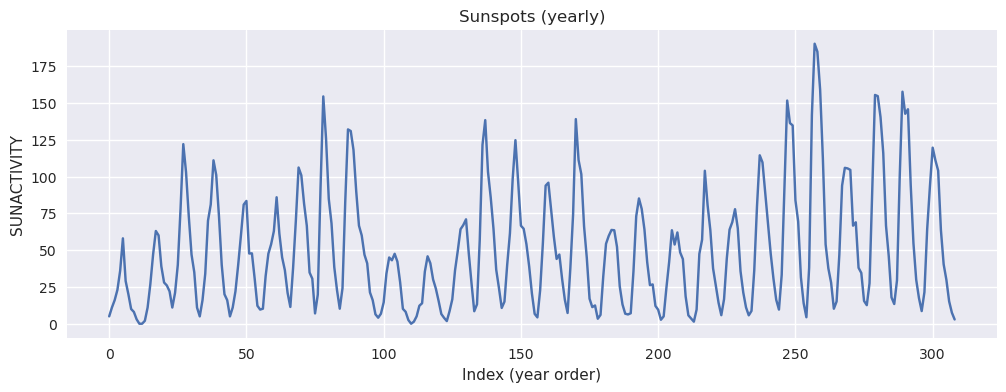

0     5.0
1    11.0
2    16.0
3    23.0
4    36.0
Name: SUNACTIVITY, dtype: float64

In [2]:
from statsmodels.datasets import sunspots

# load_pandas() 返回 DataFrame，这里取出 SUNACTIVITY 这一列
sun = sunspots.load_pandas().data
sun_ts = sun["SUNACTIVITY"].copy()

plt.figure(figsize=(12, 4))
plt.plot(sun_ts)
plt.title("Sunspots (yearly)")
plt.xlabel("Index (year order)")
plt.ylabel("SUNACTIVITY")
plt.grid(True)
plt.show()

sun_ts.head()


## 1.2 大气 CO2（趋势 + 季节性）

- 数据含义：大气 CO2 浓度观测值（周度），存在缺失。
- 直观特征：长期上升趋势 + 每年重复的季节波动。

我们稍后会把它转换为“月度均值”来做季节性建模（周期 = 12）。


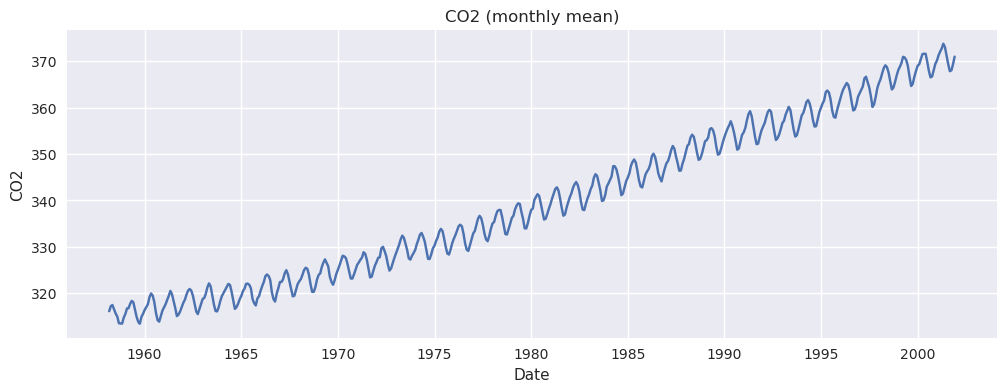

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    316.514344
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [3]:
from statsmodels.datasets import co2

co2_df = co2.load_pandas().data.copy()  # index 是日期

# 周度 -> 月度均值，并用时间插值补齐缺失
co2_monthly = co2_df["co2"].resample("MS").mean().interpolate("time")

plt.figure(figsize=(12, 4))
plt.plot(co2_monthly)
plt.title("CO2 (monthly mean)")
plt.xlabel("Date")
plt.ylabel("CO2")
plt.grid(True)
plt.show()

co2_monthly.head()


# 二、ARIMA 建模：一套通用流程

面对一个新的时间序列，典型流程如下：

1. **可视化**：先看趋势/季节性/异常点。
2. **平稳性检验（ADF）**：判断是否需要差分（确定 d）。
3. **差分**：一阶差分消趋势；季节差分消季节性。
4. **ACF/PACF**：为 p、q 提供候选范围（不是“绝对答案”，但很好用）。
5. **拟合模型**：ARIMA 或 SARIMAX。
6. **诊断残差**：
   - Ljung-Box：残差在前 m 个滞后是否“整体无自相关”。
   - 残差图/残差 ACF：是否还存在结构。
7. **预测**：生成预测并可视化置信区间。


## 工具函数（ADF / ACF&PACF / Ljung-Box）

后面我们会重复用这些工具函数，让代码更清晰。


In [4]:
def adf_test(ts: pd.Series, name: str = "series") -> None:
    """ADF 检验：
    H0：序列存在单位根（非平稳）
    H1：序列平稳
    """
    ts = ts.dropna()
    stat, pvalue, usedlag, nobs, crit, _ = adfuller(ts)
    print(f"[ADF] {name}")
    print(f"  statistic = {stat:.4f}")
    print(f"  p-value   = {pvalue:.4g}")
    print(f"  usedlag   = {usedlag}, nobs = {nobs}")
    print("  critical values:")
    for k, v in crit.items():
        print(f"    {k}: {v:.4f}")
    if pvalue <= 0.05:
        print("  结论：拒绝 H0（更像平稳）")
    else:
        print("  结论：无法拒绝 H0（更像非平稳，考虑差分）")


def plot_acf_pacf(ts: pd.Series, lags: int = 40, title: str = "") -> None:
    """绘制 ACF/PACF。建议传入已经（近似）平稳的序列。"""
    ts = ts.dropna()
    fig, axes = plt.subplots(2, 1, figsize=(12, 7))
    plot_acf(ts, lags=lags, ax=axes[0])
    plot_pacf(ts, lags=lags, ax=axes[1], method="ywm")
    axes[0].set_title("ACF")
    axes[1].set_title("PACF")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def ljung_box_test(resid: pd.Series, lags: int = 20) -> pd.DataFrame:
    """Ljung-Box：检验残差在前 lags 个滞后是否整体无自相关。"""
    resid = pd.Series(resid).dropna()
    return acorr_ljungbox(resid, lags=lags, return_df=True)


# 三、案例 A：平稳序列（用 AR 模型练“读 summary + 残差诊断”）

为了让你把注意力放在“模型输出怎么读”上，这里先用一个**人工生成的平稳 AR(2) 序列**来练习：

- 你会看到：ADF 往往判定平稳；ACF/PACF 也较容易给出 p 的线索。
- 然后我们拟合 `ARIMA(2,0,0)`（也就是 AR(2)），再做 Ljung-Box。


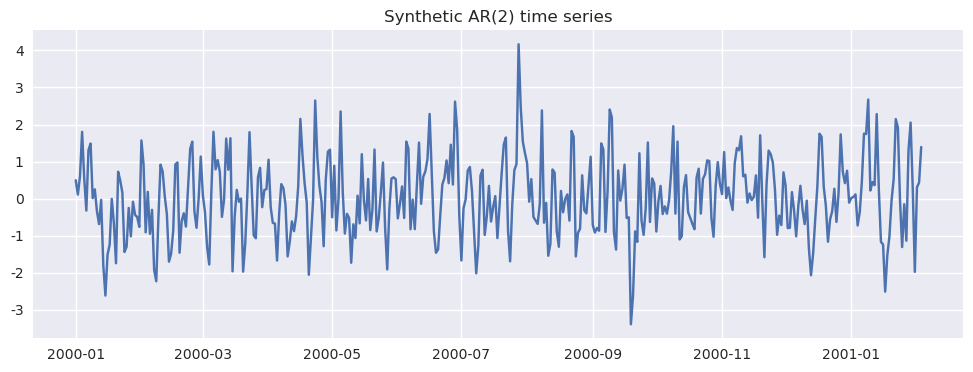

2000-01-01    0.496714
2000-01-02    0.110093
2000-01-03    0.603392
2000-01-04    1.802707
2000-01-05    0.546522
Freq: D, Name: x, dtype: float64

In [5]:
# 生成一个 AR(2) 序列：x_t = 0.5 x_{t-1} - 0.2 x_{t-2} + e_t
# 注意：ArmaProcess 的参数是多项式系数：AR = [1, -phi1, -phi2, ...]

np.random.seed(42)

phi1, phi2 = 0.5, -0.2
ar = np.array([1, -phi1, -phi2])
ma = np.array([1])

process = ArmaProcess(ar, ma)
x = process.generate_sample(nsample=400)

ts_stationary = pd.Series(x, index=pd.date_range("2000-01-01", periods=len(x), freq="D"), name="x")

plt.figure(figsize=(12, 4))
plt.plot(ts_stationary)
plt.title("Synthetic AR(2) time series")
plt.grid(True)
plt.show()

ts_stationary.head()


## 3.1 平稳性（ADF）与 ACF/PACF

对平稳序列来说，我们通常不需要差分：`d = 0`。


[ADF] Synthetic AR(2)
  statistic = -13.3329
  p-value   = 6.133e-25
  usedlag   = 1, nobs = 398
  critical values:
    1%: -3.4469
    5%: -2.8688
    10%: -2.5707
  结论：拒绝 H0（更像平稳）


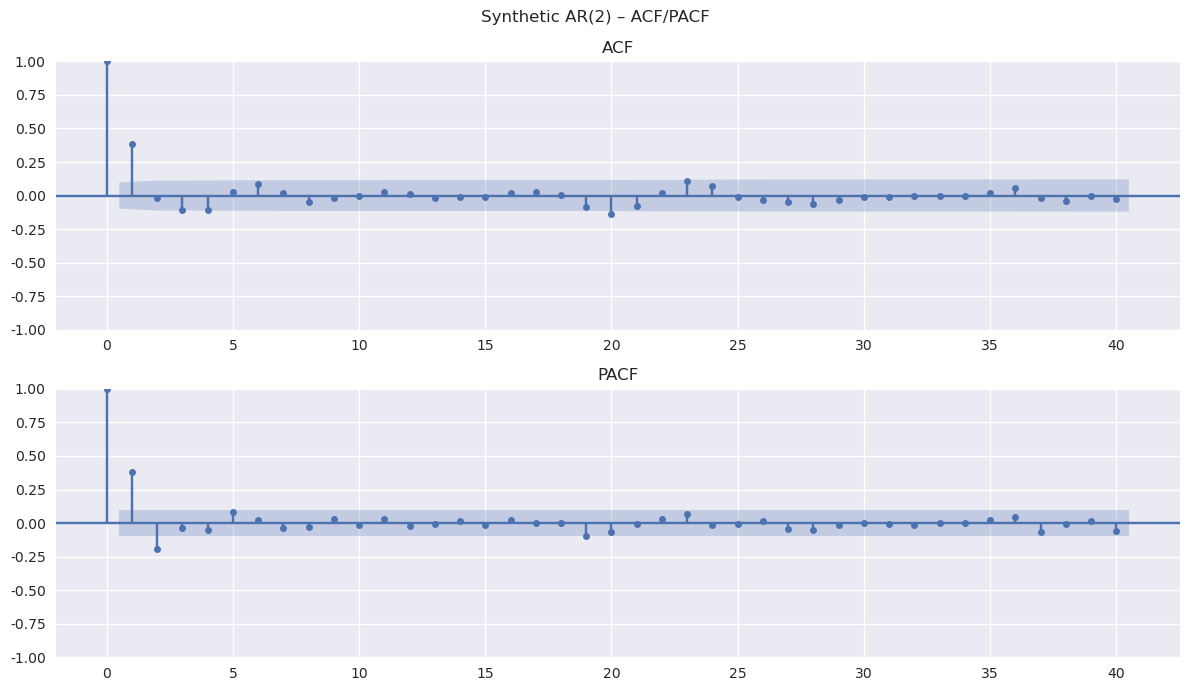

In [6]:
adf_test(ts_stationary, name="Synthetic AR(2)")
plot_acf_pacf(ts_stationary, lags=40, title="Synthetic AR(2) – ACF/PACF")


## 3.2 拟合 ARIMA(2,0,0) 并读懂 summary

拟合 `ARIMA(2,0,0)`，然后重点看 summary 里的这几列：

- `coef`：系数的点估计值（模型“学到的”最可能系数）。
- `std err`：系数估计的不确定性（标准误），越小通常越稳定。
- `P>|z|`：显著性检验 p 值（常用 0.05 作为阈值）。
- `[0.025, 0.975]`：95% 置信区间。

经验判断：
- 置信区间**不包含 0** ≈ p 值小于 0.05（该系数显著不为 0）。
- 置信区间包含 0 ≈ p 值大于 0.05（无法排除该系数为 0）。


                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  400
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -550.601
Date:                Fri, 09 Jan 2026   AIC                           1109.202
Time:                        18:20:08   BIC                           1125.168
Sample:                    01-01-2000   HQIC                          1115.525
                         - 02-03-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0324      0.066      0.489      0.625      -0.097       0.162
ar.L1          0.4582      0.052      8.742      0.000       0.355       0.561
ar.L2         -0.1904      0.052     -3.649      0.0

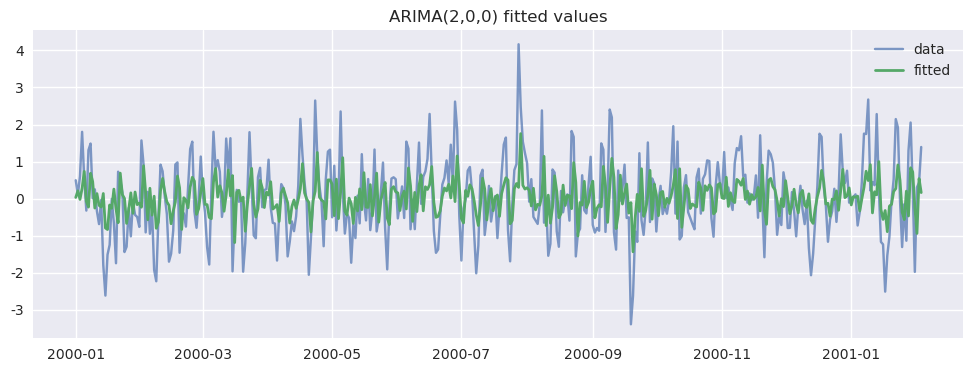

In [7]:
# 拟合 AR(2)
model_a = ARIMA(ts_stationary, order=(2, 0, 0))
result_a = model_a.fit()

print(result_a.summary())

# 简单画一下“拟合值 vs 原序列”（仅作为直观参考）
plt.figure(figsize=(12, 4))
plt.plot(ts_stationary, label="data", alpha=0.7)
plt.plot(result_a.fittedvalues, label="fitted", linewidth=2)
plt.title("ARIMA(2,0,0) fitted values")
plt.legend()
plt.grid(True)
plt.show()


## 3.3 残差诊断：Ljung-Box（非常重要）

Ljung-Box 的原假设：

- **H0**：残差在前 m 个滞后“整体没有自相关”（常被理解为“像白噪声”）。

如何解读 p 值：

- p 值 **小**：拒绝 H0 → 残差仍有结构 → 模型可能没吃干净信息（需要改进）。
- p 值 **大**：无法拒绝 H0 → **没有证据**表明残差有自相关结构。

注意：p 值大并不等于“证明残差一定是白噪声”，更准确的表述是：

> 在你选定的滞后范围内，我们没有检测到显著的自相关结构。


In [8]:
# Ljung-Box 检验：看多个滞后的 p 值
lb_a = ljung_box_test(result_a.resid, lags=20)
lb_a.tail()


,lb_stat,lb_pvalue
16,7.810661,0.954304
17,7.813081,0.970382
18,7.958325,0.979250
19,9.287628,0.968391
20,12.814091,0.885217


# 四、案例 B：趋势 + 季节性（CO2）

CO2 月度序列同时存在：

- 趋势：长期上升（非平稳）。
- 季节性：每年重复的波动。

对这种序列，经典做法有两种：

1. **手动差分**（季节差分 + 一阶差分），然后用 ARIMA 拟合差分后的序列。
2. 直接用 **SARIMAX**（带季节项的 ARIMA），让模型内部处理季节结构。

这里我们演示更常用、更省事的第 2 种：SARIMAX。


## 4.1 先确认非平稳（ADF）

通常这种“明显趋势”的序列，ADF 会倾向于给出较大的 p 值（无法拒绝单位根）。


In [9]:
adf_test(co2_monthly, name="CO2 monthly")


[ADF] CO2 monthly
  statistic = 2.2340
  p-value   = 0.9989
  usedlag   = 14, nobs = 511
  critical values:
    1%: -3.4432
    5%: -2.8672
    10%: -2.5698
  结论：无法拒绝 H0（更像非平稳，考虑差分）


## 4.2 季节性差分 + 一阶差分（帮助我们理解 D、d）

定义：

- 一阶差分（消趋势）：`y_t - y_{t-1}`
- 季节差分（周期 m=12，消季节性）：`y_t - y_{t-12}`

在 SARIMAX 记号里：

- `d`：非季节差分次数（通常 0 或 1）。
- `D`：季节差分次数（通常 0 或 1）。


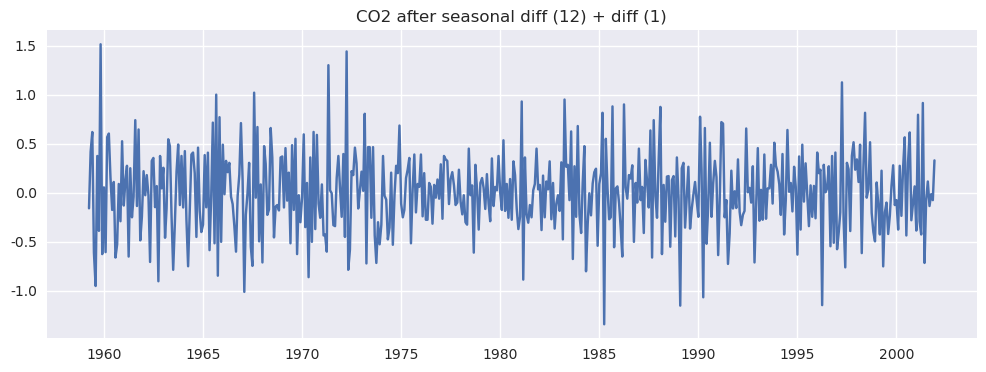

[ADF] CO2 after (D=1, d=1)
  statistic = -8.4006
  p-value   = 2.236e-13
  usedlag   = 15, nobs = 497
  critical values:
    1%: -3.4436
    5%: -2.8674
    10%: -2.5699
  结论：拒绝 H0（更像平稳）


In [10]:
m = 12  # 月度数据的季节周期

# 先季节差分
co2_seasonal_diff = co2_monthly.diff(m)

# 再做一阶差分
co2_stationary_like = co2_seasonal_diff.diff(1)

plt.figure(figsize=(12, 4))
plt.plot(co2_stationary_like)
plt.title("CO2 after seasonal diff (12) + diff (1)")
plt.grid(True)
plt.show()

adf_test(co2_stationary_like, name="CO2 after (D=1, d=1)")


## 4.3 用 ACF/PACF 给 (p,q)(P,Q) 提示

提醒：ACF/PACF 给的是“经验线索”，不是定阶的唯一依据。最终通常结合：

- AIC/BIC（越小越好，比较不同候选模型）
- 残差诊断（尤其 Ljung-Box）


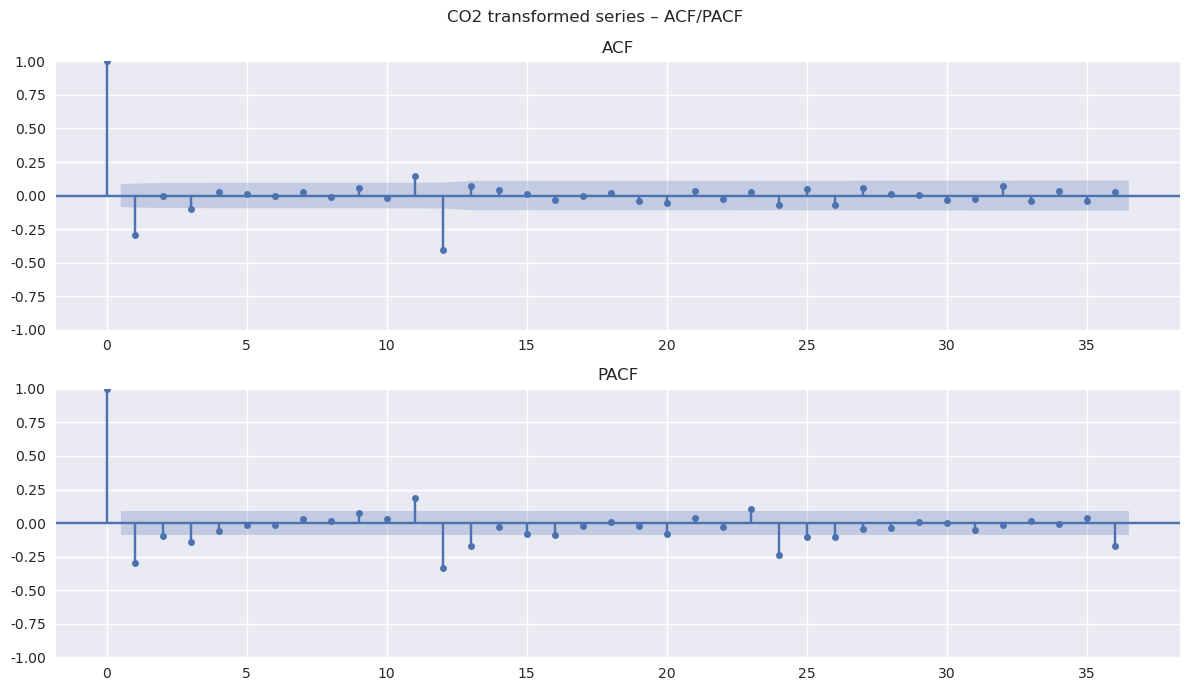

In [11]:
plot_acf_pacf(co2_stationary_like, lags=36, title="CO2 transformed series – ACF/PACF")


## 4.4 拟合 SARIMAX（带季节项的 ARIMA）

一个常见的起手式（不是唯一答案）：

- 非季节部分：`(p, d, q) = (1, 1, 1)`
- 季节部分：`(P, D, Q, m) = (1, 1, 1, 12)`

你可以把它理解为：

- `d=1`：用一阶差分消趋势
- `D=1, m=12`：用 12 期季节差分消季节性
- 其他 AR/MA 项先从 1 开始试，再用 AIC/BIC + 残差诊断迭代。


In [12]:
# 拟合 SARIMAX：直接在原序列上建模（模型内部做差分）
model_b = SARIMAX(
    co2_monthly,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
result_b = model_b.fit(disp=False)

print(result_b.summary())
print("AIC:", result_b.aic)


                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -102.133
Date:                            Fri, 09 Jan 2026   AIC                            214.266
Time:                                    18:20:10   BIC                            235.329
Sample:                                03-01-1958   HQIC                           222.532
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1594      0.122      1.309      0.190      -0.079       0.398
ma.L1         -0.5011      0.109   

## 4.5 残差诊断（Ljung-Box）

我们希望：

- 在一段合理的滞后范围内，Ljung-Box 的 p 值不要系统性地很小。

如果很多滞后都显著（p 很小），通常意味着：

- 阶数不合适（p/q/P/Q 需要调整）
- 差分设置不合适（d/D）
- 序列可能需要额外处理（缺失、异常点、变换等）


In [13]:
lb_b = ljung_box_test(result_b.resid, lags=24)
lb_b.tail()


,lb_stat,lb_pvalue
20,118.902768,4.551025e-16
21,118.904380,1.133798e-15
22,118.904393,2.757052e-15
23,118.905373,6.544617e-15
24,118.905691,1.519213e-14


## 4.6 预测未来 12 个月

预测时通常会同时画出：

- 真实历史序列
- 预测均值（点预测）
- 置信区间（不确定性范围）


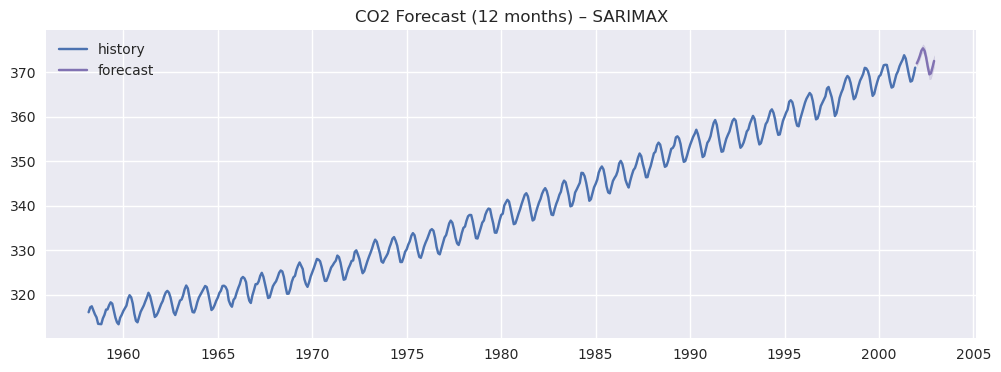

In [14]:
forecast_steps = 12
pred = result_b.get_forecast(steps=forecast_steps)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(12, 4))
plt.plot(co2_monthly, label="history")
plt.plot(pred_mean, label="forecast", color="C3")
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="C3", alpha=0.2)
plt.title("CO2 Forecast (12 months) – SARIMAX")
plt.legend()
plt.grid(True)
plt.show()


# 五、回顾与总结

1. **滞后（lag）**：`x_{t-k}` 表示 k 期之前的值。
2. **ARIMA(p,d,q)**：
   - `d` 处理趋势（差分让序列更平稳）
   - `p/q` 用 ACF/PACF 给候选，再用 AIC/残差诊断迭代
3. **SARIMAX**：在 ARIMA 基础上加入季节项 `(P,D,Q,m)`，处理季节性更自然。
4. **Ljung-Box**：
   - p 值小：残差仍有结构（模型可能不够）
   - p 值大：没有证据表明残差有显著自相关（更像白噪声）

